In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sys.path.append('/Users/yilewang/workspaces/tvbtools/')
from tools import statools
from scipy.signal import decimate


In [55]:
import numpy as np
import scipy.signal


def compute_PLV(ts1, ts2):
    # Apply the Hilbert transform to each time series
    hilbert_transform_ts1 = scipy.signal.hilbert(ts1)
    hilbert_transform_ts2 = scipy.signal.hilbert(ts2)

    # Get the instantaneous phase
    instantaneous_phase_ts1 = np.angle(hilbert_transform_ts1)
    instantaneous_phase_ts2 = np.angle(hilbert_transform_ts2)

    # Calculate the phase difference
    phase_difference = instantaneous_phase_ts1 - instantaneous_phase_ts2

    # Calculate PLV
    PLV = np.abs(np.sum(np.exp(1j*phase_difference)))/len(phase_difference)
    
    return PLV




def calculate_pac(data_low, data_high, num_bins=18):
    # Hilbert Transform to get phase and amplitude
    analytic_low = scipy.signal.hilbert(data_low)
    analytic_high = scipy.signal.hilbert(data_high)

    phase_low = np.angle(analytic_low)
    amplitude_high = np.abs(analytic_high)

    # Binning
    bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    bin_idx = np.digitize(phase_low, bins)  # this gives us which bin each phase point belongs to
    mean_amp_per_bin = np.array([np.nanmean(amplitude_high[bin_idx == b]) for b in range(1, num_bins+1)]) # handle nans

    # Calculate PAC as Modulation Index using Kullback-Leibler Divergence
    p = mean_amp_per_bin / np.sum(mean_amp_per_bin)  # Convert mean amplitudes to probabilities
    p_uniform = np.ones_like(p) / len(p)  # Uniform distribution
    kl_divergence = np.sum(p * np.log(p / p_uniform))  # Kullback-Leibler Divergence

    return kl_divergence

from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filter your data
fs = 4096.0  # Sample rate
lowcut_phase = 4.0  # Low cut-off frequency for phase-providing signal
highcut_phase = 8.0  # High cut-off frequency for phase-providing signal
lowcut_amp = 30.0  # Low cut-off frequency for amplitude-providing signal
highcut_amp = 150.0  # High cut-off frequency for amplitude-providing signal

df = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')
groups = ['SNC', 'NC', 'MCI', 'AD']


# create a pandas dataframe to store the PAC values
pac_left = []
pac_right = []
pac_diff = []

for grp, sbj, gc in zip(df['group'], df['caseid'],df['Gc']):
    path = '/Users/yilewang/workspaces/data4project/lateralization/LFP_critical/'+grp+'/'+sbj+'_'+str(gc)+'.csv'
    single_sim = pd.read_csv(path)
    signal_left = single_sim['pCNG-L']
    signal_right = single_sim['pCNG-R']

    num_samples_down = 4096  # the desired number of samples after downsampling
    x_down_left = scipy.signal.resample(signal_left, num_samples_down)
    x_down_right = scipy.signal.resample(signal_right, num_samples_down)


    # Suppose 'data' is your time-series data
    data_low_left = butter_bandpass_filter(x_down_left, lowcut_phase, highcut_phase, fs, order=2)
    data_high_left = butter_bandpass_filter(x_down_left, lowcut_amp, highcut_amp, fs, order=2)
    data_low_right = butter_bandpass_filter(x_down_right, lowcut_phase, highcut_phase, fs, order=2)
    data_high_right = butter_bandpass_filter(x_down_right, lowcut_amp, highcut_amp, fs, order=2)

    plv_l = compute_PLV(data_low_left, data_low_right)
    plv_h = compute_PLV(data_high_left, data_high_right)

    # Then calculate PAC
    pac_value_left = calculate_pac(data_low_left, data_high_left)
    pac_value_right = calculate_pac(data_low_right, data_high_right)

    pac_left.append(pac_value_left)
    pac_right.append(pac_value_right)
    pac_diff.append(pac_value_left-pac_value_right)

# create a pandas dataframe with group, caseid, PAC_left, PAC_right
pac_df = pd.DataFrame({'group': df['group'], 'caseid': df['caseid'], 'PAC_left': pac_left, 'PAC_right': pac_right, 'PAC_diff': pac_diff})
# create a violin plot with PAC_left and PAC_right next to each other


In [56]:
print(pac_df)

   group caseid  PAC_left  PAC_right  PAC_diff
0    SNC  2820A  0.531939   0.459740  0.072200
1    SNC  3168A  0.478960   0.372933  0.106026
2    SNC  3358A  0.559808   0.733734 -0.173926
3    SNC  3610A  0.639012   0.413510  0.225502
4    SNC  4073A  0.450047   0.631917 -0.181870
..   ...    ...       ...        ...       ...
69    AD  3255A  0.534925   0.654737 -0.119813
70    AD  4612A  0.558120   0.557003  0.001116
71    AD  5368A  0.454010   0.380326  0.073684
72    AD  5571A  0.673202   0.701587 -0.028385
73    AD  7673A  0.448502   0.455657 -0.007155

[74 rows x 5 columns]


In [57]:
print(statools.stats_calculator(pac_df, tails="twosides"))

           (SNC, NC)  (SNC, MCI)  (SNC, AD)  (NC, MCI)  (NC, AD)  (MCI, AD)
PAC_left    0.772823    0.772823   0.772823   0.772823  0.772823   0.772823
PAC_right   0.667333    0.950705   0.816158   0.491051  0.491051   0.816158
PAC_diff    0.963804    0.963804   0.963804   0.963804  0.963804   0.963804


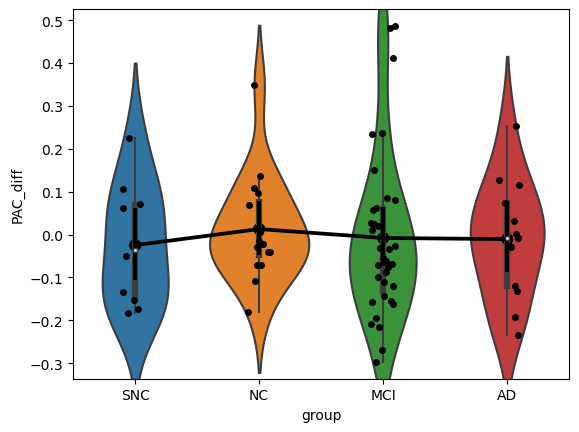

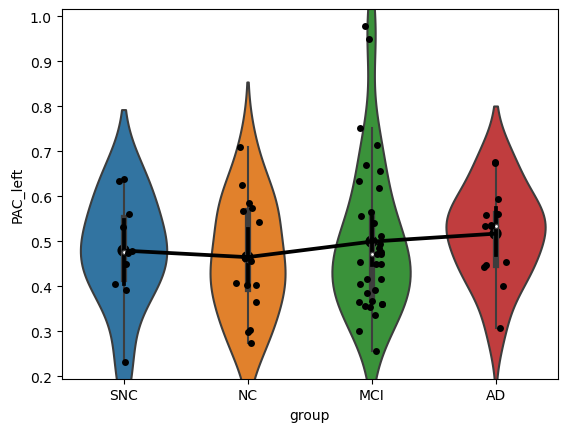

In [58]:
sns.violinplot(x='group', y='PAC_diff', data=pac_df)
sns.stripplot(x='group', y='PAC_diff', data=pac_df, jitter=True, color='black')
sns.pointplot(x='group', y='PAC_diff', data=pac_df, color='black')
plt.show()

sns.violinplot(x='group', y='PAC_left', data=pac_df)
sns.stripplot(x='group', y='PAC_left', data=pac_df, jitter=True, color='black')
sns.pointplot(x='group', y='PAC_left', data=pac_df, color='black')
plt.show()

# comodulograms plot

In [80]:
df = pd.read_excel('/Users/yat-lok/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')
groups = ['SNC', 'NC', 'MCI', 'AD']

def comodulograms(signal, fs=819, low_fq_width=1.0, low_fq_range=np.linspace(1,10,50), methods='duprelatour'):
    # Compute the comodulograms and plot them
    print('%s... ' % (methods, ))
    estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                                low_fq_width=low_fq_width, method=methods,
                                progress_bar=False)
    estimator.fit(signal)
    # estimator.plot()
    return estimator.comod_

collect_left = np.empty((50, 80, len(df['group'])))
collect_right = np.empty((50, 80, len(df['group'])))

index=0

for grp, sbj, gc in zip(df['group'], df['caseid'],df['Gc']):
    try:
        path = '/Users/yat-lok/workspaces/data4project/lateralization/LFP_critical/'+grp+'/'+sbj+'_'+str(gc)+'.csv'
        single_sim = pd.read_csv(path)
        signal_left = single_sim['pCNG-L']
        signal_left_down = decimate(signal_left, 100)
        signal_left_filtered = SignalToolkit.sos_filter(signal_left_down, win=[0.5, 400], fs=819)

        signal_right = single_sim['pCNG-R']
        signal_right_down = decimate(signal_right, 100)
        signal_right_filtered = SignalToolkit.sos_filter(signal_right_down, win=[0.5, 400], fs=819)
        collect_left[:,:,index] = comodulograms(signal_left_filtered)
        collect_right[:,:,index] = comodulograms(signal_right_filtered)
        index+=1
    except FileNotFoundError:
        continue

duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelat

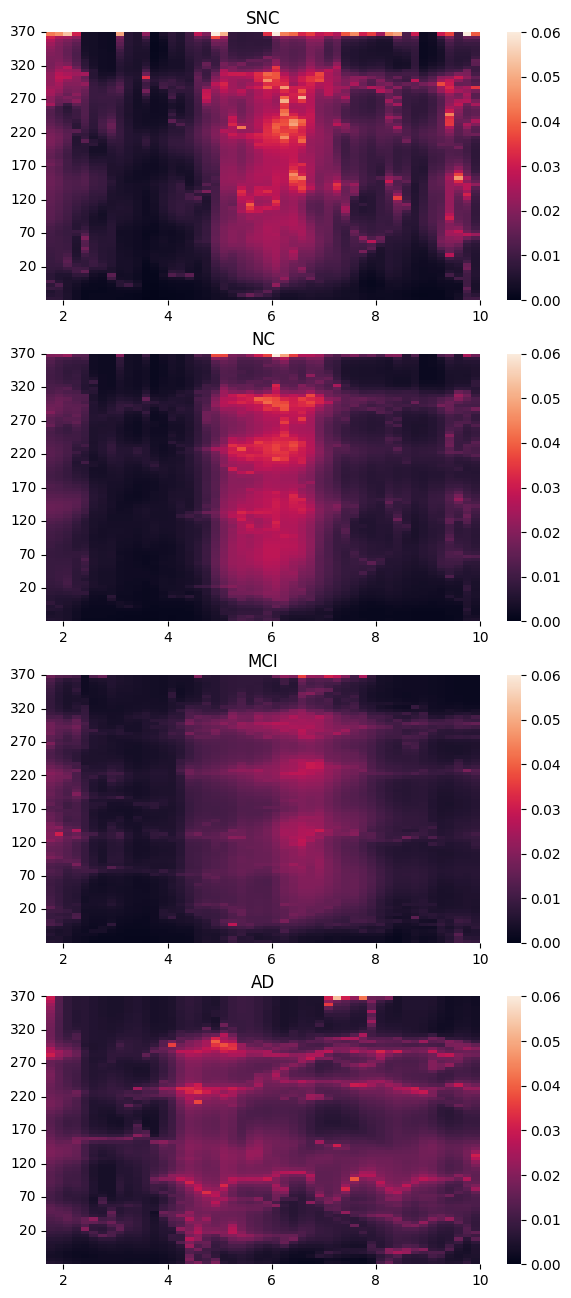

In [88]:
SNC = 10
NC = 10+16
MCI = 10+16+35

diff_collect = collect_left

SNC_diff = np.mean(diff_collect[:,:,:SNC], axis=2)
NC_diff = np.mean(diff_collect[:,:,:NC], axis=2) 
MCI_diff = np.mean(diff_collect[:,:,NC:MCI], axis=2)
AD_diff = np.mean(diff_collect[:,:,MCI:], axis=2)


# SNC_diff = np.mean(collect_left[:,:,:SNC], axis=2) - np.mean(collect_right[:,:,:SNC], axis=2)
# NC_diff = np.mean(collect_left[:,:,SNC:NC], axis=2) - np.mean(collect_right[:,:,SNC:NC], axis=2)
# MCI_diff = np.mean(collect_left[:,:,NC:MCI], axis=2) - np.mean(collect_right[:,:,NC:MCI], axis=2)
# AD_diff = np.mean(collect_left[:,:,MCI:], axis=2) - np.mean(collect_right[:,:,MCI:], axis=2)

title = ['SNC', 'NC', 'MCI', 'AD']

def pac_plot(matrix, title, index):
    sns.heatmap(matrix.T,vmin = 0, vmax=0.06, ax=axs[index])
    axs[index].invert_yaxis()
    axs[index].set_title(title)
    # axs[index].set_xlabel('Theta Frequency (Hz)')
    axs[index].set_xticks(np.arange(2, 51, 12))
    axs[index].set_xticklabels(np.arange(2, 11, 2), rotation=0)
    # plt.ylabel('Gamma Frequency (Hz)')
    axs[index].set_yticks(np.arange(10,81,10))
    axs[index].set_yticklabels(np.arange(20,400,50), rotation=0)


summary = [SNC_diff, NC_diff, MCI_diff, AD_diff]
fig, axs = plt.subplots(4,1, figsize=(7,16))
axs = axs.ravel()
for index, i in enumerate(summary):
    pac_plot(i, title[index], index)
plt.show()